# Imports

In [177]:
import matplotlib as mpl

import matplotlib.pyplot as plt
# plt.style.use('seaborn-talk')
mpl.rcParams['figure.figsize'] = [10, 8]
mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Computer Modern Roman'
mpl.rcParams['lines.linewidth'] = 1.25
mpl.rcParams['lines.markersize'] = 6
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import h5py
import sys
import os
import time as TIME
import multiprocessing as mprocs
from threading import Thread
from subprocess import Popen, PIPE
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import zip_longest
from matplotlib.gridspec import GridSpec
from matplotlib.pyplot import cm 
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
from numba import jit
import random

In [178]:
k0 = 1
alpha = 1.4
beta  = 0.0
iters = 400000
N     = 64

filename = "/LCE_Runtime_Data_N[{}]_k0[{}]_ALPHA[{:0.3f}]_BETA[{:0.3f}]_u0[ALIGNED]_ITERS[{}]".format(N, k0, alpha, beta, iters)
input_dir  = "/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/Output/LCE"
# output_dir = "/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/Snapshots/TriadDynamics" + filename
HDFfileData = h5py.File(input_dir + filename + '.h5', 'r')


In [106]:
## Create the triads from the phases
@jit(nopython = True)
def compute_triads(phases, kmin, kmax):
    print("\n...Computing Triads...\n")

    ## Variables
    numTriads  = 0;
    k3_range   = int(kmax - kmin + 1)
    k1_range   = int((kmax - kmin + 1) / 2)
    time_steps = phases.shape[0]

    ## Create memory space
    triadphase = -10 * np.ones((k3_range, k1_range, time_steps))
    triads     = -10 * np.ones((k3_range, k1_range, time_steps))
    phaseOrder = np.complex(0.0, 0.0) * np.ones((time_steps))
    R          = np.zeros((time_steps))
    Phi        = np.zeros((time_steps))

    ## Compute the triads
    for k in range(kmin, kmax + 1):
        for k1 in range(kmin, int(k/2) + 1):
            triadphase[k - kmin, k1 - kmin, :] = phases[:, k1] + phases[:, k - k1] - phases[:, k]
            triads[k - kmin, k1 - kmin, :]     = np.mod(triadphase[k - kmin, k1 - kmin, :], 2*np.pi)

            phaseOrder[:] += np.exp(np.complex(0.0, 1.0)*triads[k - kmin, k1 - kmin, :])
            numTriads += 1

    # Compute Phase-Order params
    R[:]   = np.absolute(phaseOrder[:] / numTriads)
    Phi[:] = np.angle(phaseOrder[:] / numTriads)

    return triads, R, Phi

In [107]:
phases = HDFfileData['Phases'][:, :]
time   = HDFfileData['Time'][:, :]
amps   = HDFfileData['Amps'][:, :]


ntsteps = phases.shape[0];
num_osc = phases.shape[1];
N       = 2 * num_osc - 1 - 1;
kmin    = k0 + 1;
kmax    = amps.shape[1] - 1
k0      = kmin - 1;
if 'Triads' in list(HDFfileData.keys()):
    R      = HDFfileData['PhaseOrderR'][:, :]
    Phi    = HDFfileData['PhaseOrderPhi'][:, :]
    triad  = HDFfileData['Triads']
    # Reshape triads
    tdims     = triad.attrs['Triad_Dims']
    triads    = np.array(np.reshape(triad, np.append(triad.shape[0], tdims[0, :])))

    triads_exist = 1
else:
    ## Call triad function
    triads, R, Phi = compute_triads(phases, kmin, kmax)
    triads_exist = 0

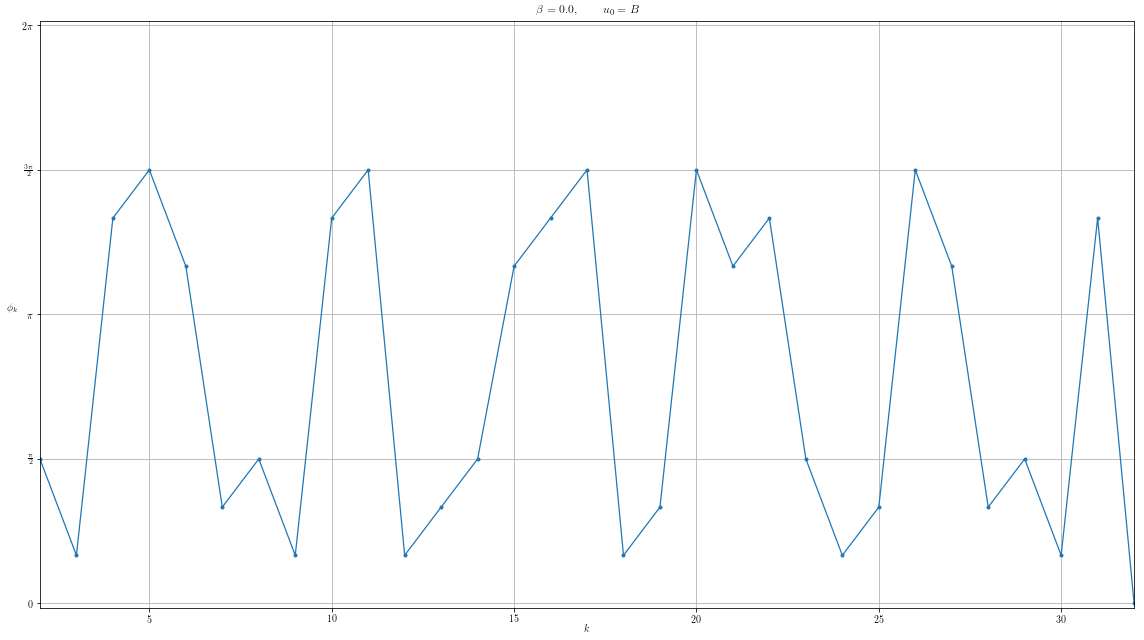

In [84]:
mpl.rcParams['figure.figsize'] = [16, 9]
plt.plot(np.arange(kmin, num_osc), np.mod(fixedpt_phi[kmin:], 2*np.pi), '.-')
plt.xlim(kmin, kmax)
plt.ylim([0- 0.05, 2 * np.pi + 0.05])
# plt.ylim([-2 * np.pi + 0.05, 2 * np.pi + 0.05])
plt.xlabel(r'$k$', labelpad = 0)
plt.ylabel(r'$\phi_k$', rotation = 0, labelpad = 10)
plt.title(r"$\beta = {}, \qquad u_0 = {}$".format(0.0, "E") )
# plt.xticks(np.arange(kmin, num_osc), np.arange(kmin, num_osc))
plt.yticks([0, np.pi / 2.0, np.pi, 3.0 * np.pi / 2.0, 2.0 * np.pi], [r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"])
# plt.yticks(np.append(np.flipud([-np.pi / 2.0, -np.pi, -3.0 * np.pi / 2.0, -2.0 * np.pi]), [0, np.pi / 2.0, np.pi, 3.0 * np.pi / 2.0, 2.0 * np.pi]), np.append(np.flipud([r"$-\frac{\pi}{2}$", r"$-\pi$", r"$-\frac{3\pi}{2}$", r"$-2\pi$"]),[r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]))
plt.grid(True)
plt.show()

# Compute Fixed Point B - (Post Breather/Limit Cycle Fixed Point)

In [62]:
k0 = 1
alpha = 1.4
beta  = 0.0
iters = 400000
N     = 64

triadarr = -10.0 * np.ones(num_osc)
triadarr[kmin:] = np.pi/2
triadarr[[10, 12, 14, 23, 25, 27]] = -np.pi/2
print(triadarr)

[-10.         -10.           1.57079633   1.57079633   1.57079633
   1.57079633   1.57079633   1.57079633   1.57079633   1.57079633
  -1.57079633   1.57079633  -1.57079633   1.57079633  -1.57079633
   1.57079633   1.57079633   1.57079633   1.57079633   1.57079633
   1.57079633   1.57079633   1.57079633  -1.57079633   1.57079633
  -1.57079633   1.57079633  -1.57079633   1.57079633   1.57079633
   1.57079633   1.57079633   1.57079633]


In [63]:
fixedpt_phi = np.zeros(len(np.arange(0, kmax + 1)))
len(fixedpt_phi)

# initial phase values, worked out by hand
fixedpt_phi[kmin]     = np.pi /2.0       # phi_2
fixedpt_phi[kmin + 1] = 0.0           # phi_3


for k in range(kmin, kmax - kmin + 1):
    fixedpt_phi[k + 2] = -triadarr[k] + fixedpt_phi[k] + fixedpt_phi[kmin]

print(fixedpt_phi)
print(np.mod(fixedpt_phi, 2.0*np.pi))

[ 0.          0.          1.57079633  0.          1.57079633  0.
  1.57079633  0.          1.57079633  0.          1.57079633  0.
  4.71238898  0.          7.85398163  0.         10.99557429  0.
 10.99557429  0.         10.99557429  0.         10.99557429  0.
 10.99557429  3.14159265 10.99557429  6.28318531 10.99557429  9.42477796
 10.99557429  9.42477796 10.99557429]
[0.         0.         1.57079633 0.         1.57079633 0.
 1.57079633 0.         1.57079633 0.         1.57079633 0.
 4.71238898 0.         1.57079633 0.         4.71238898 0.
 4.71238898 0.         4.71238898 0.         4.71238898 0.
 4.71238898 3.14159265 4.71238898 0.         4.71238898 3.14159265
 4.71238898 3.14159265 4.71238898]


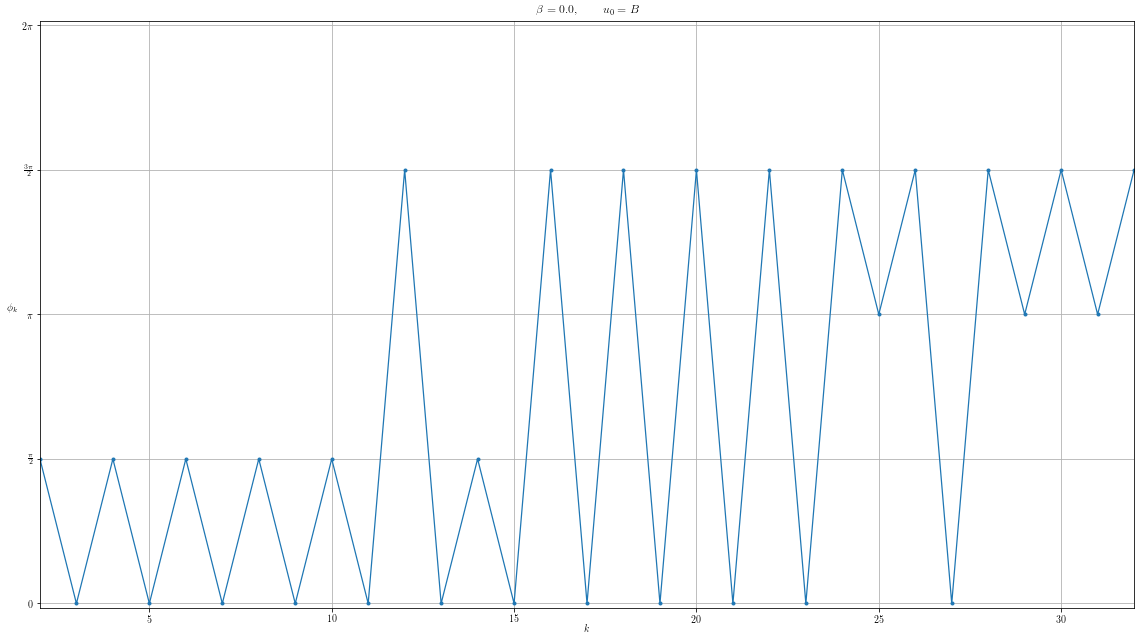

In [64]:
mpl.rcParams['figure.figsize'] = [16, 9]
plt.plot(np.arange(kmin, num_osc), np.mod(fixedpt_phi[kmin:], 2*np.pi), '.-')
plt.xlim(kmin, kmax)
plt.ylim([0- 0.05, 2 * np.pi + 0.05])
# plt.ylim([-2 * np.pi + 0.05, 2 * np.pi + 0.05])
plt.xlabel(r'$k$', labelpad = 0)
plt.ylabel(r'$\phi_k$', rotation = 0, labelpad = 10)
plt.title(r"$\beta = {}, \qquad u_0 = {}$".format(0.0, "B") )
# plt.xticks(np.arange(kmin, num_osc), np.arange(kmin, num_osc))
plt.yticks([0, np.pi / 2.0, np.pi, 3.0 * np.pi / 2.0, 2.0 * np.pi], [r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"])
# plt.yticks(np.append(np.flipud([-np.pi / 2.0, -np.pi, -3.0 * np.pi / 2.0, -2.0 * np.pi]), [0, np.pi / 2.0, np.pi, 3.0 * np.pi / 2.0, 2.0 * np.pi]), np.append(np.flipud([r"$-\frac{\pi}{2}$", r"$-\pi$", r"$-\frac{3\pi}{2}$", r"$-2\pi$"]),[r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]))
plt.grid(True)
plt.show()

## Compare Fixed Point B at N = 64 and N = 128

[-10.         -10.           1.57079633   1.57079633   1.57079633
   1.57079633   1.57079633   1.57079633   1.57079633   1.57079633
  -1.57079633   1.57079633  -1.57079633   1.57079633  -1.57079633
   1.57079633   1.57079633   1.57079633   1.57079633   1.57079633
   1.57079633   1.57079633   1.57079633  -1.57079633   1.57079633
  -1.57079633   1.57079633  -1.57079633   1.57079633   1.57079633
   1.57079633   1.57079633   1.57079633]
[ 0.          0.          4.71238898  7.85398163  7.85398163 10.99557429
 10.99557429 14.13716694 14.13716694 17.27875959 17.27875959 20.42035225
 23.5619449  23.5619449  29.84513021 26.70353756 36.12831552 29.84513021
 39.26990817 32.98672286 42.41150082 36.12831552 45.55309348 39.26990817
 48.69468613 45.55309348 51.83627878 51.83627878 54.97787144 58.11946409
 58.11946409 61.26105675 61.26105675]
[0.         0.         4.71238898 1.57079633 1.57079633 4.71238898
 4.71238898 1.57079633 1.57079633 4.71238898 4.71238898 1.57079633
 4.71238898 4.71238898 4.7

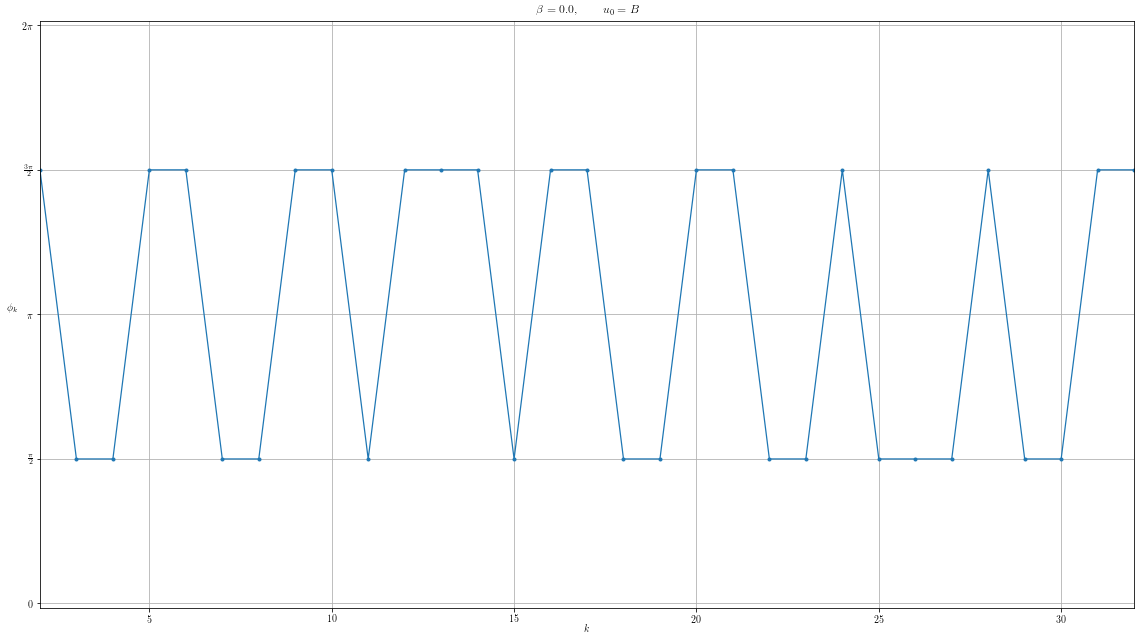

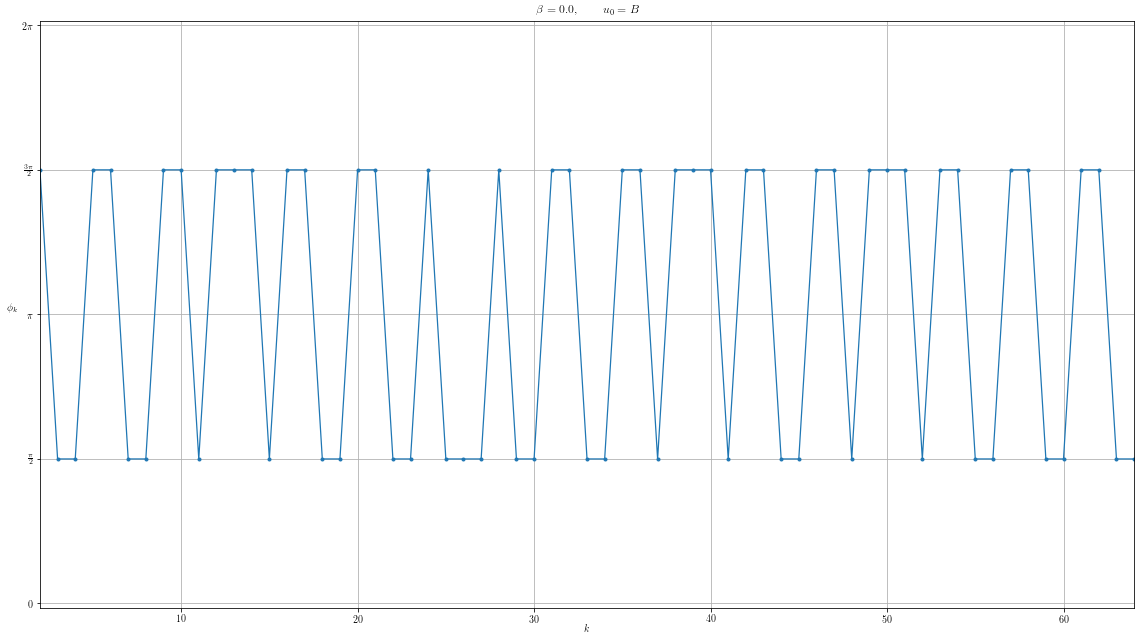

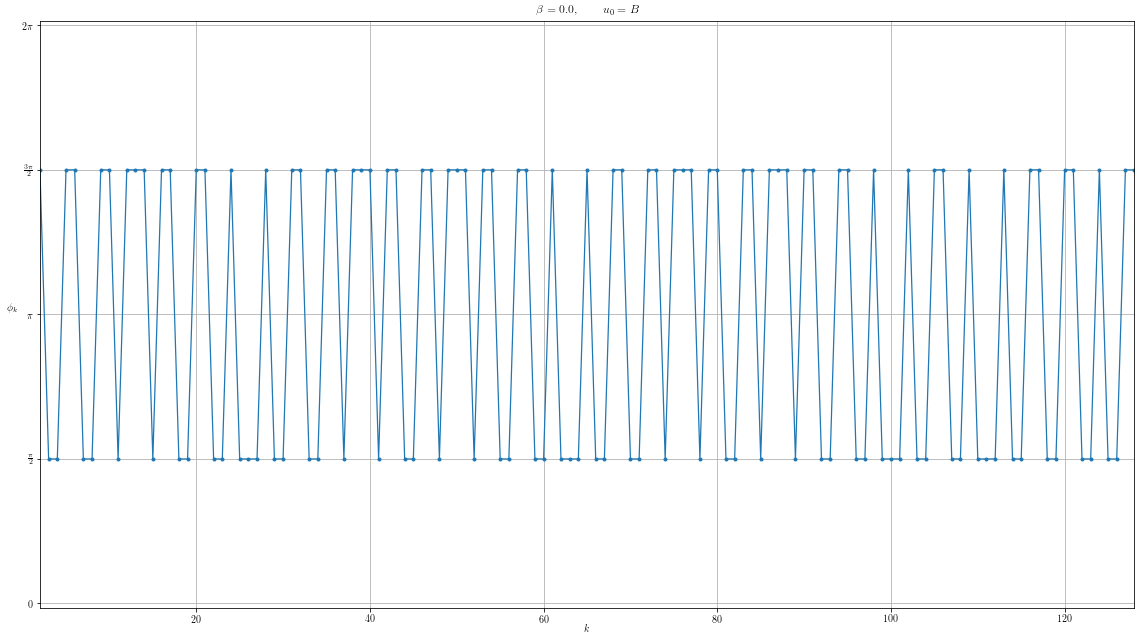

In [174]:
u0 = "B"
N = 64;
num_osc = int(N / 2 + 1);
kmin    = int(k0 + 1);
kmax    = int(N / 2);


triadarr = -10.0 * np.ones(num_osc)
triadarr[kmin:]                                            = np.pi/2
triadarr[[10, 12, 14, 23, 25, 27]] = -np.pi/2 #36, 38, 40, 47, 49, 51
print(triadarr)

fixedpt_phi = np.zeros(len(np.arange(0, kmax + 1)))
len(fixedpt_phi)

# initial phase values, worked out by hand
fixedpt_phi[kmin]     = 3.0*np.pi /2.0       # phi_2
fixedpt_phi[kmin + 1] = 5.0*np.pi /2.0       # phi_3


for k in range(kmin, kmax - kmin + 1):
    fixedpt_phi[k + 2] = -triadarr[k] + fixedpt_phi[k] + fixedpt_phi[kmin]

print(fixedpt_phi)
print(np.mod(fixedpt_phi, 2.0*np.pi))

mpl.rcParams['figure.figsize'] = [16, 9]
plt.plot(np.arange(kmin, num_osc), np.mod(fixedpt_phi[kmin:], 2*np.pi), '.-')
plt.xlim(kmin, kmax)
plt.ylim([0- 0.05, 2 * np.pi + 0.05])
# plt.ylim([-2 * np.pi + 0.05, 2 * np.pi + 0.05])
plt.xlabel(r'$k$', labelpad = 0)
plt.ylabel(r'$\phi_k$', rotation = 0, labelpad = 10)
plt.title(r"$\beta = {}, \qquad u_0 = {}$".format(0.0, "B") )
# plt.xticks(np.arange(kmin, num_osc), np.arange(kmin, num_osc))
plt.yticks([0, np.pi / 2.0, np.pi, 3.0 * np.pi / 2.0, 2.0 * np.pi], [r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"])
# plt.yticks(np.append(np.flipud([-np.pi / 2.0, -np.pi, -3.0 * np.pi / 2.0, -2.0 * np.pi]), [0, np.pi / 2.0, np.pi, 3.0 * np.pi / 2.0, 2.0 * np.pi]), np.append(np.flipud([r"$-\frac{\pi}{2}$", r"$-\pi$", r"$-\frac{3\pi}{2}$", r"$-2\pi$"]),[r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]))
plt.grid(True)
plt.show()

## Write fixed point to file
np.savetxt("../Data/Input/Initial_Conditions/FixedPoint_N[{}]_k0[{}]_BETA[{:0.3f}]_u0[{}].txt".format(N, k0, beta, u0), np.mod(fixedpt_phi, 2.0*np.pi), fmt = "%20.16f")


N = 128;
num_osc = int(N / 2 + 1);
kmin    = int(k0 + 1);
kmax    = int(N / 2);


triadarr = -10.0 * np.ones(num_osc)
triadarr[kmin:]                                            = np.pi/2
triadarr[[10, 12, 14, 23, 25, 27, 36, 38, 40, 47, 49, 51]] = -np.pi/2 #
# print(triadarr)

fixedpt_phi = np.zeros(len(np.arange(0, kmax + 1)))
len(fixedpt_phi)

# initial phase values, worked out by hand
fixedpt_phi[kmin]     = 3.0*np.pi /2.0       # phi_2
fixedpt_phi[kmin + 1] = 5.0*np.pi /2.0       # phi_3


for k in range(kmin, kmax - kmin + 1):
    fixedpt_phi[k + 2] = -triadarr[k] + fixedpt_phi[k] + fixedpt_phi[kmin]

# print(fixedpt_phi)
# print(np.mod(fixedpt_phi, 2.0*np.pi))

mpl.rcParams['figure.figsize'] = [16, 9]
plt.plot(np.arange(kmin, num_osc), np.mod(fixedpt_phi[kmin:], 2*np.pi), '.-')
plt.xlim(kmin, kmax)
plt.ylim([0- 0.05, 2 * np.pi + 0.05])
# plt.ylim([-2 * np.pi + 0.05, 2 * np.pi + 0.05])
plt.xlabel(r'$k$', labelpad = 0)
plt.ylabel(r'$\phi_k$', rotation = 0, labelpad = 10)
plt.title(r"$\beta = {}, \qquad u_0 = {}$".format(0.0, "B") )
# plt.xticks(np.arange(kmin, num_osc), np.arange(kmin, num_osc))
plt.yticks([0, np.pi / 2.0, np.pi, 3.0 * np.pi / 2.0, 2.0 * np.pi], [r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"])
# plt.yticks(np.append(np.flipud([-np.pi / 2.0, -np.pi, -3.0 * np.pi / 2.0, -2.0 * np.pi]), [0, np.pi / 2.0, np.pi, 3.0 * np.pi / 2.0, 2.0 * np.pi]), np.append(np.flipud([r"$-\frac{\pi}{2}$", r"$-\pi$", r"$-\frac{3\pi}{2}$", r"$-2\pi$"]),[r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]))
plt.grid(True)
plt.show()


np.savetxt("../Data/Input/Initial_Conditions/FixedPoint_N[{}]_k0[{}]_BETA[{:0.3f}]_u0[{}].txt".format(N, k0, beta, u0), np.mod(fixedpt_phi, 2.0*np.pi), fmt = "%20.16f")


N = 256;
num_osc = int(N / 2 + 1);
kmin    = int(k0 + 1);
kmax    = int(N / 2);


triadarr = -10.0 * np.ones(num_osc)
triadarr[kmin:]                                            = np.pi/2
triadarr[[10, 12, 14, 23, 25, 27, 36, 38, 40, 47, 49, 51, 60, 62, 64, 73, 75, 77, 84, 86, 88, 97, 99, 101, 108, 110, 112, 123]] = -np.pi/2 #
# print(triadarr)

fixedpt_phi = np.zeros(len(np.arange(0, kmax + 1)))
len(fixedpt_phi)

# initial phase values, worked out by hand
fixedpt_phi[kmin]     = 3.0*np.pi /2.0       # phi_2
fixedpt_phi[kmin + 1] = 5.0*np.pi /2.0       # phi_3


for k in range(kmin, kmax - kmin + 1):
    fixedpt_phi[k + 2] = -triadarr[k] + fixedpt_phi[k] + fixedpt_phi[kmin]

# print(fixedpt_phi)
# print(np.mod(fixedpt_phi, 2.0*np.pi))

mpl.rcParams['figure.figsize'] = [16, 9]
plt.plot(np.arange(kmin, num_osc), np.mod(fixedpt_phi[kmin:], 2*np.pi), '.-')
plt.xlim(kmin, kmax)
plt.ylim([0- 0.05, 2 * np.pi + 0.05])
# plt.ylim([-2 * np.pi + 0.05, 2 * np.pi + 0.05])
plt.xlabel(r'$k$', labelpad = 0)
plt.ylabel(r'$\phi_k$', rotation = 0, labelpad = 10)
plt.title(r"$\beta = {}, \qquad u_0 = {}$".format(0.0, "B") )
# plt.xticks(np.arange(kmin, num_osc), np.arange(kmin, num_osc))
plt.yticks([0, np.pi / 2.0, np.pi, 3.0 * np.pi / 2.0, 2.0 * np.pi], [r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"])
# plt.yticks(np.append(np.flipud([-np.pi / 2.0, -np.pi, -3.0 * np.pi / 2.0, -2.0 * np.pi]), [0, np.pi / 2.0, np.pi, 3.0 * np.pi / 2.0, 2.0 * np.pi]), np.append(np.flipud([r"$-\frac{\pi}{2}$", r"$-\pi$", r"$-\frac{3\pi}{2}$", r"$-2\pi$"]),[r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]))
plt.grid(True)
plt.show()


np.savetxt("../Data/Input/Initial_Conditions/FixedPoint_N[{}]_k0[{}]_BETA[{:0.3f}]_u0[{}].txt".format(N, k0, beta, u0), np.mod(fixedpt_phi, 2.0*np.pi), fmt = "%20.16f")

## Create Initial Conditions of Fixed Point B for larger systesm

[0.         0.         4.71238898 1.57079633 1.57079633 4.71238898
 4.71238898 1.57079633 1.57079633 4.71238898 4.71238898 1.57079633
 4.71238898 4.71238898 4.71238898 1.57079633 4.71238898 4.71238898
 1.57079633 1.57079633 4.71238898 4.71238898 1.57079633 1.57079633
 4.71238898 1.57079633 1.57079633 1.57079633 4.71238898 1.57079633
 1.57079633 4.71238898 4.71238898 1.57079633 1.57079633 4.71238898
 4.71238898 1.57079633 4.71238898 4.71238898 4.71238898 1.57079633
 4.71238898 4.71238898 1.57079633 1.57079633 4.71238898 4.71238898
 1.57079633 4.71238898 4.71238898 4.71238898 1.57079633 4.71238898
 4.71238898 1.57079633 1.57079633 4.71238898 4.71238898 1.57079633
 1.57079633 4.71238898 1.57079633 1.57079633 1.57079633 4.71238898
 1.57079633 1.57079633 4.71238898 4.71238898 1.57079633 1.57079633
 4.71238898 4.71238898 1.57079633 4.71238898 4.71238898 4.71238898
 1.57079633 4.71238898 4.71238898 1.57079633 1.57079633 4.71238898
 4.71238898 1.57079633 4.71238898 4.71238898 4.71238898 1.5707

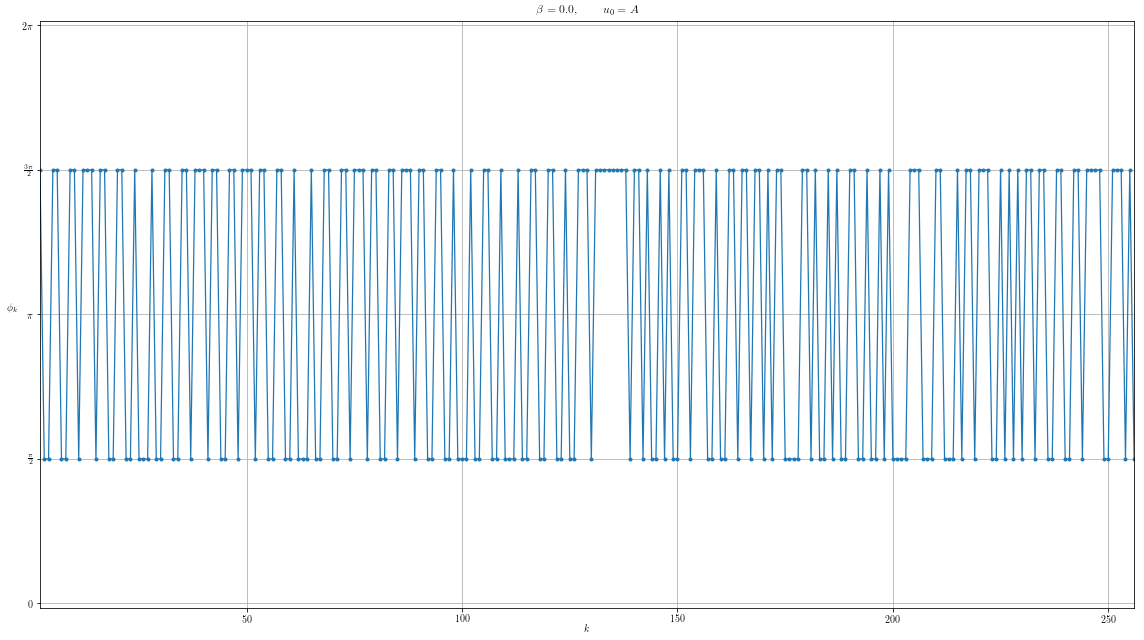

In [176]:
## Create initial conditions using fixed point A for larger systems
u0 = "B"
N = [512] 

for n in N:
    new_fixed_pt = np.zeros((int(n/2 + 1),))

    random.seed(123456789)

    for i in range(len(new_fixed_pt)):
        if i < len(fixedpt_phi):
            new_fixed_pt[i] = np.mod(fixedpt_phi[i], 2.0*np.pi)
        elif u0 == "B_RANDOM":
            new_fixed_pt[i] = random.random() * 2.0 * np.pi
        elif u0 == "B_ZERO":
            new_fixed_pt[i] = 0.0
        else:
            num = random.getrandbits(1)
            new_fixed_pt[i] = np.mod(((-1)**num) * np.pi / 2, 2.0 * np.pi)

    print(new_fixed_pt)

    mpl.rcParams['figure.figsize'] = [16, 9]
    plt.plot(np.arange(kmin, n/ 2 + 1), new_fixed_pt[kmin:], '.-')
    plt.xlim(kmin, n/ 2)
    plt.ylim([0- 0.05, 2 * np.pi + 0.05])
    # plt.ylim([-2 * np.pi + 0.05, 2 * np.pi + 0.05])
    plt.xlabel(r'$k$', labelpad = 0)
    plt.ylabel(r'$\phi_k$', rotation = 0, labelpad = 10)
    plt.title(r"$\beta = {}, \qquad u_0 = {}$".format(0.0, "B") )
    # plt.xticks(np.arange(kmin, num_osc), np.arange(kmin, num_osc))
    plt.yticks([0, np.pi / 2.0, np.pi, 3.0 * np.pi / 2.0, 2.0 * np.pi], [r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"])
    # plt.yticks(np.append(np.flipud([-np.pi / 2.0, -np.pi, -3.0 * np.pi / 2.0, -2.0 * np.pi]), [0, np.pi / 2.0, np.pi, 3.0 * np.pi / 2.0, 2.0 * np.pi]), np.append(np.flipud([r"$-\frac{\pi}{2}$", r"$-\pi$", r"$-\frac{3\pi}{2}$", r"$-2\pi$"]),[r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]))
    plt.grid(True)
    plt.show()


    np.savetxt("../Data/Input/Initial_Conditions/FixedPoint_N[{}]_k0[{}]_BETA[{:0.3f}]_u0[{}].txt".format(n, k0, beta, u0),  np.mod(new_fixed_pt, 2.0*np.pi), fmt = "%20.16f")

# Fixed Point A - (Pre Breather/Limit Cycle Fixed Piont)

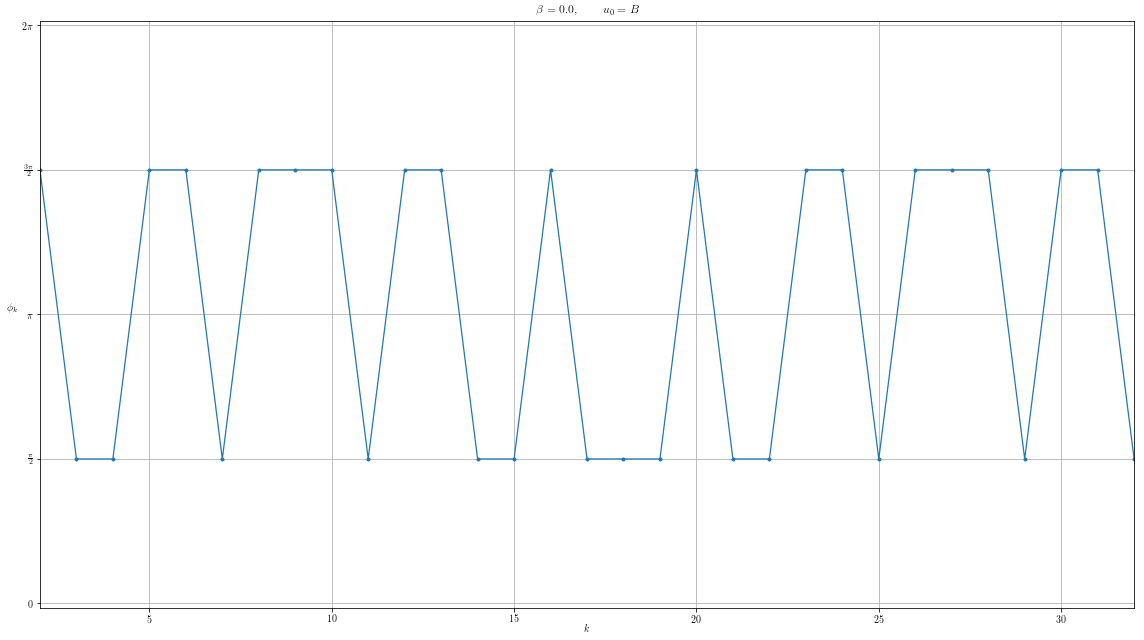

In [165]:
u0 = "A"
N = 64;
num_osc = int(N / 2 + 1);
kmin    = int(k0 + 1);
kmax    = int(N / 2);


triadarr = -10.0 * np.ones(num_osc)
triadarr[kmin:]                              = np.pi/2
triadarr[[6, 8, 10, 15, 17, 19, 24, 26, 28]] = -np.pi/2 #
# print(triadarr)

fixedpt_phi = np.zeros(len(np.arange(0, kmax + 1)))
len(fixedpt_phi)

# initial phase values, worked out by hand
fixedpt_phi[kmin]     = 3.0 * np.pi /2.0       # phi_2
fixedpt_phi[kmin + 1] = 5.0 * np.pi /2.0       # phi_3


for k in range(kmin, kmax - kmin + 1):
    fixedpt_phi[k + 2] = -triadarr[k] + fixedpt_phi[k] + fixedpt_phi[kmin]

# print(fixedpt_phi)
# print(np.mod(fixedpt_phi, 2.0*np.pi))

mpl.rcParams['figure.figsize'] = [16, 9]
plt.plot(np.arange(kmin, num_osc), np.mod(fixedpt_phi[kmin:], 2*np.pi), '.-')
plt.xlim(kmin, kmax)
plt.ylim([0- 0.05, 2 * np.pi + 0.05])
# plt.ylim([-2 * np.pi + 0.05, 2 * np.pi + 0.05])
plt.xlabel(r'$k$', labelpad = 0)
plt.ylabel(r'$\phi_k$', rotation = 0, labelpad = 10)
plt.title(r"$\beta = {}, \qquad u_0 = {}$".format(0.0, "B") )
# plt.xticks(np.arange(kmin, num_osc), np.arange(kmin, num_osc))
plt.yticks([0, np.pi / 2.0, np.pi, 3.0 * np.pi / 2.0, 2.0 * np.pi], [r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"])
# plt.yticks(np.append(np.flipud([-np.pi / 2.0, -np.pi, -3.0 * np.pi / 2.0, -2.0 * np.pi]), [0, np.pi / 2.0, np.pi, 3.0 * np.pi / 2.0, 2.0 * np.pi]), np.append(np.flipud([r"$-\frac{\pi}{2}$", r"$-\pi$", r"$-\frac{3\pi}{2}$", r"$-2\pi$"]),[r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]))
plt.grid(True)
plt.show()


np.savetxt("../Data/Input/Fixed_Points/FixedPoint_N[{}]_k0[{}]_BETA[{:0.3f}]_u0[{}].txt".format(N, k0, beta, u0),  np.mod(fixedpt_phi, 2.0*np.pi), fmt = "%20.16f")
np.savetxt("../Data/Input/Initial_Conditions/FixedPoint_N[{}]_k0[{}]_BETA[{:0.3f}]_u0[{}].txt".format(N, k0, beta, u0),  np.mod(fixedpt_phi, 2.0*np.pi), fmt = "%20.16f")

[0.         0.         4.71238898 1.57079633 1.57079633 4.71238898
 4.71238898 1.57079633 4.71238898 4.71238898 4.71238898 1.57079633
 4.71238898 4.71238898 1.57079633 1.57079633 4.71238898 1.57079633
 1.57079633 1.57079633 4.71238898 1.57079633 1.57079633 4.71238898
 4.71238898 1.57079633 4.71238898 4.71238898 4.71238898 1.57079633
 4.71238898 4.71238898 1.57079633 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]


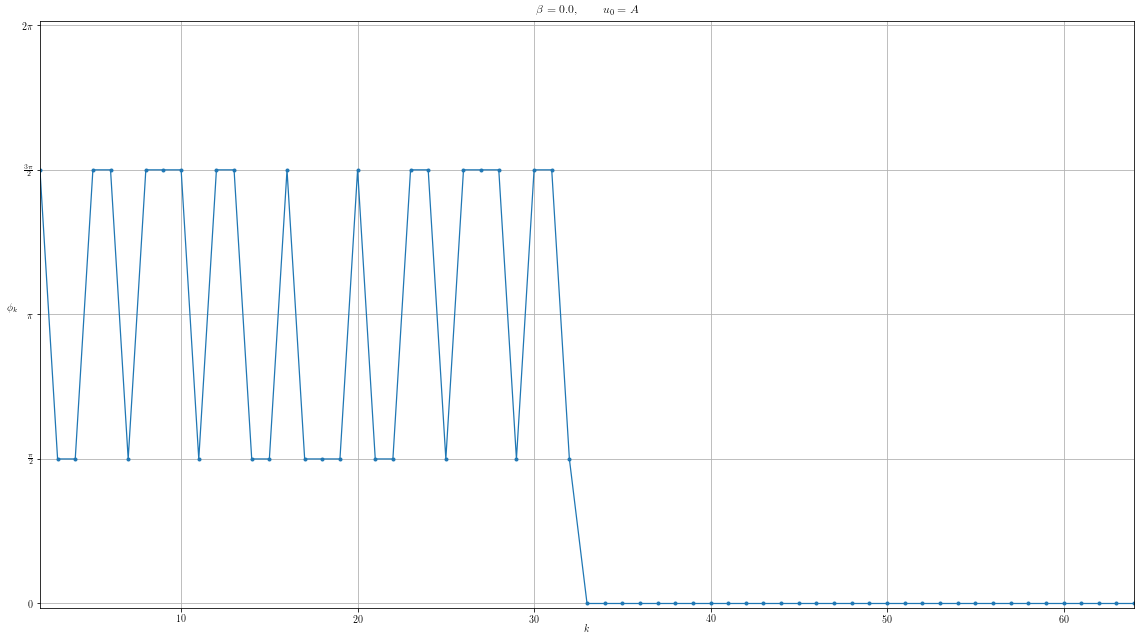

[0.         0.         4.71238898 1.57079633 1.57079633 4.71238898
 4.71238898 1.57079633 4.71238898 4.71238898 4.71238898 1.57079633
 4.71238898 4.71238898 1.57079633 1.57079633 4.71238898 1.57079633
 1.57079633 1.57079633 4.71238898 1.57079633 1.57079633 4.71238898
 4.71238898 1.57079633 4.71238898 4.71238898 4.71238898 1.57079633
 4.71238898 4.71238898 1.57079633 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.  

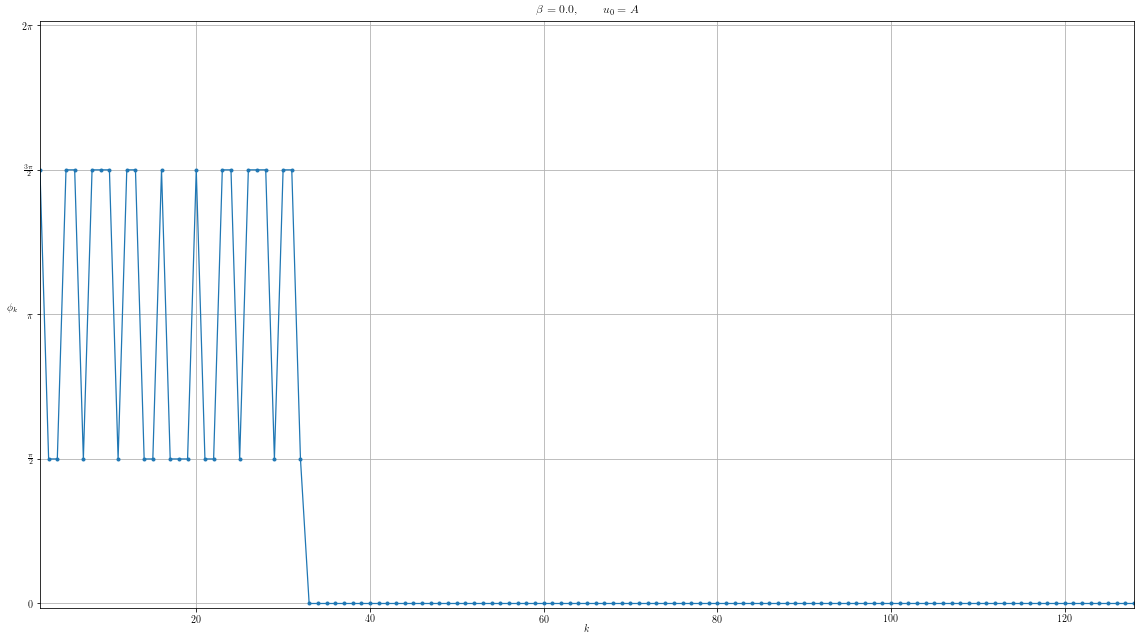

[0.         0.         4.71238898 1.57079633 1.57079633 4.71238898
 4.71238898 1.57079633 4.71238898 4.71238898 4.71238898 1.57079633
 4.71238898 4.71238898 1.57079633 1.57079633 4.71238898 1.57079633
 1.57079633 1.57079633 4.71238898 1.57079633 1.57079633 4.71238898
 4.71238898 1.57079633 4.71238898 4.71238898 4.71238898 1.57079633
 4.71238898 4.71238898 1.57079633 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.  

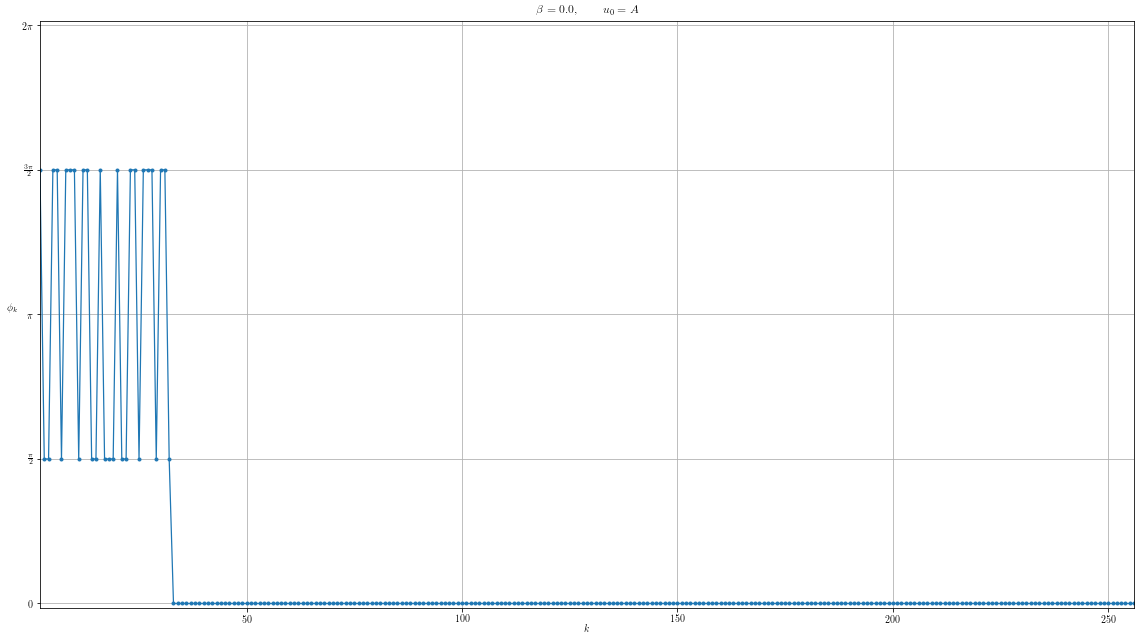

In [168]:
## Create initial conditions using fixed point A for larger systems
u0 = "A_ZERO"
N = [128, 256, 512] 

for n in N:
    new_fixed_pt = np.zeros((int(n/2 + 1),))

    random.seed(123456789)

    for i in range(len(new_fixed_pt)):
        if i < len(fixedpt_phi):
            new_fixed_pt[i] = np.mod(fixedpt_phi[i], 2.0*np.pi)
        elif u0 == "A_RANDOM":
            new_fixed_pt[i] = random.random() * 2.0 * np.pi
        elif u0 == "A_ZERO":
            new_fixed_pt[i] = 0.0
        else:
            num = random.getrandbits(1)
            new_fixed_pt[i] = np.mod(((-1)**num) * np.pi / 2, 2.0 * np.pi)

    print(new_fixed_pt)

    mpl.rcParams['figure.figsize'] = [16, 9]
    plt.plot(np.arange(kmin, n/ 2 + 1), new_fixed_pt[kmin:], '.-')
    plt.xlim(kmin, n/ 2)
    plt.ylim([0- 0.05, 2 * np.pi + 0.05])
    # plt.ylim([-2 * np.pi + 0.05, 2 * np.pi + 0.05])
    plt.xlabel(r'$k$', labelpad = 0)
    plt.ylabel(r'$\phi_k$', rotation = 0, labelpad = 10)
    plt.title(r"$\beta = {}, \qquad u_0 = {}$".format(0.0, "A") )
    # plt.xticks(np.arange(kmin, num_osc), np.arange(kmin, num_osc))
    plt.yticks([0, np.pi / 2.0, np.pi, 3.0 * np.pi / 2.0, 2.0 * np.pi], [r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"])
    # plt.yticks(np.append(np.flipud([-np.pi / 2.0, -np.pi, -3.0 * np.pi / 2.0, -2.0 * np.pi]), [0, np.pi / 2.0, np.pi, 3.0 * np.pi / 2.0, 2.0 * np.pi]), np.append(np.flipud([r"$-\frac{\pi}{2}$", r"$-\pi$", r"$-\frac{3\pi}{2}$", r"$-2\pi$"]),[r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]))
    plt.grid(True)
    plt.show()


    np.savetxt("../Data/Input/Initial_Conditions/FixedPoint_N[{}]_k0[{}]_BETA[{:0.3f}]_u0[{}].txt".format(n, k0, beta, u0),  np.mod(new_fixed_pt, 2.0*np.pi), fmt = "%20.16f")

# Fixed Point C - (Another Post Breather/Limit Cycle Fixed Point)

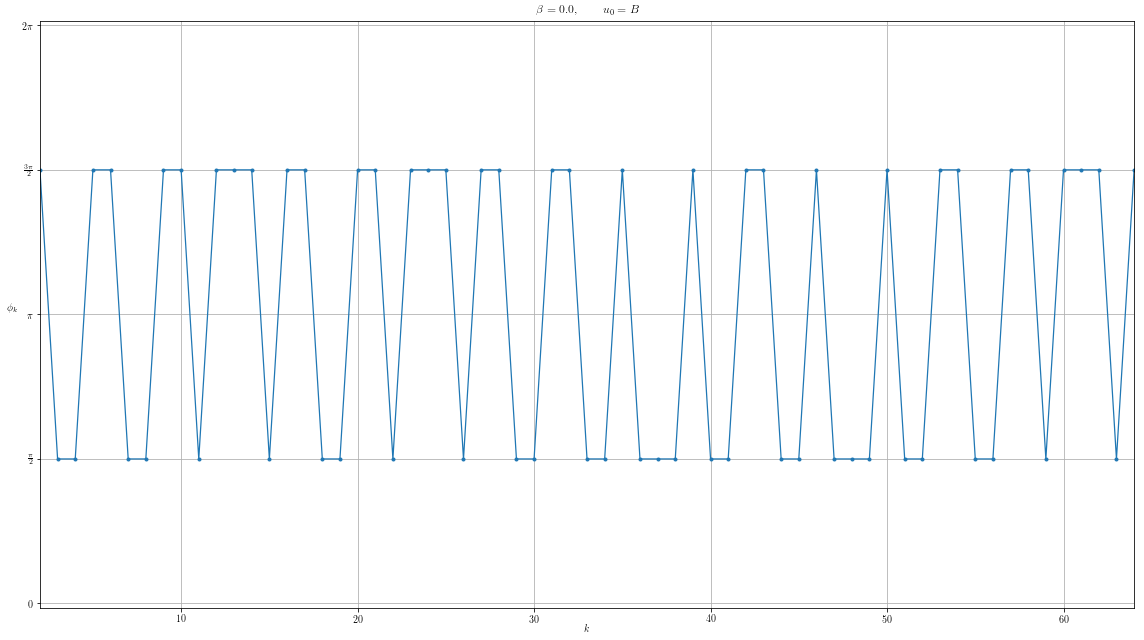

In [182]:
u0 = "C"
N = 128;
num_osc = int(N / 2 + 1);
kmin    = int(k0 + 1);
kmax    = int(N / 2);


triadarr = -10.0 * np.ones(num_osc)
triadarr[kmin:]                                                        = np.pi/2
triadarr[[10, 12, 14, 21, 23, 25, 34, 36, 38, 45, 47, 49, 58, 60, 62]] = -np.pi/2 #
# print(triadarr)

fixedpt_phi = np.zeros(len(np.arange(0, kmax + 1)))
len(fixedpt_phi)

# initial phase values, worked out by hand
fixedpt_phi[kmin]     = 3.0*np.pi /2.0       # phi_2
fixedpt_phi[kmin + 1] = 5.0*np.pi /2.0             # phi_3


for k in range(kmin, kmax - kmin + 1):
    fixedpt_phi[k + 2] = -triadarr[k] + fixedpt_phi[k] + fixedpt_phi[kmin]

# print(fixedpt_phi)
# print(np.mod(fixedpt_phi, 2.0*np.pi))

mpl.rcParams['figure.figsize'] = [16, 9]
plt.plot(np.arange(kmin, num_osc), np.mod(fixedpt_phi[kmin:], 2*np.pi), '.-')
plt.xlim(kmin, kmax)
plt.ylim([0- 0.05, 2 * np.pi + 0.05])
# plt.ylim([-2 * np.pi + 0.05, 2 * np.pi + 0.05])
plt.xlabel(r'$k$', labelpad = 0)
plt.ylabel(r'$\phi_k$', rotation = 0, labelpad = 10)
plt.title(r"$\beta = {}, \qquad u_0 = {}$".format(0.0, "B") )
# plt.xticks(np.arange(kmin, num_osc), np.arange(kmin, num_osc))
plt.yticks([0, np.pi / 2.0, np.pi, 3.0 * np.pi / 2.0, 2.0 * np.pi], [r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"])
# plt.yticks(np.append(np.flipud([-np.pi / 2.0, -np.pi, -3.0 * np.pi / 2.0, -2.0 * np.pi]), [0, np.pi / 2.0, np.pi, 3.0 * np.pi / 2.0, 2.0 * np.pi]), np.append(np.flipud([r"$-\frac{\pi}{2}$", r"$-\pi$", r"$-\frac{3\pi}{2}$", r"$-2\pi$"]),[r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]))
plt.grid(True)
plt.show()

np.savetxt("../Data/Input/Fixed_Points/FixedPoint_N[{}]_k0[{}]_BETA[{:0.3f}]_u0[{}].txt".format(N, k0, beta, u0),  np.mod(new_fixed_pt, 2.0*np.pi), fmt = "%20.16f")
np.savetxt("../Data/Input/Initial_Conditions/FixedPoint_N[{}]_k0[{}]_BETA[{:0.3f}]_u0[{}].txt".format(N, k0, beta, u0),  np.mod(new_fixed_pt, 2.0*np.pi), fmt = "%20.16f")





[0.         0.         4.71238898 1.57079633 1.57079633 4.71238898
 4.71238898 1.57079633 1.57079633 4.71238898 4.71238898 1.57079633
 4.71238898 4.71238898 4.71238898 1.57079633 4.71238898 4.71238898
 1.57079633 1.57079633 4.71238898 4.71238898 1.57079633 4.71238898
 4.71238898 4.71238898 1.57079633 4.71238898 4.71238898 1.57079633
 1.57079633 4.71238898 4.71238898]


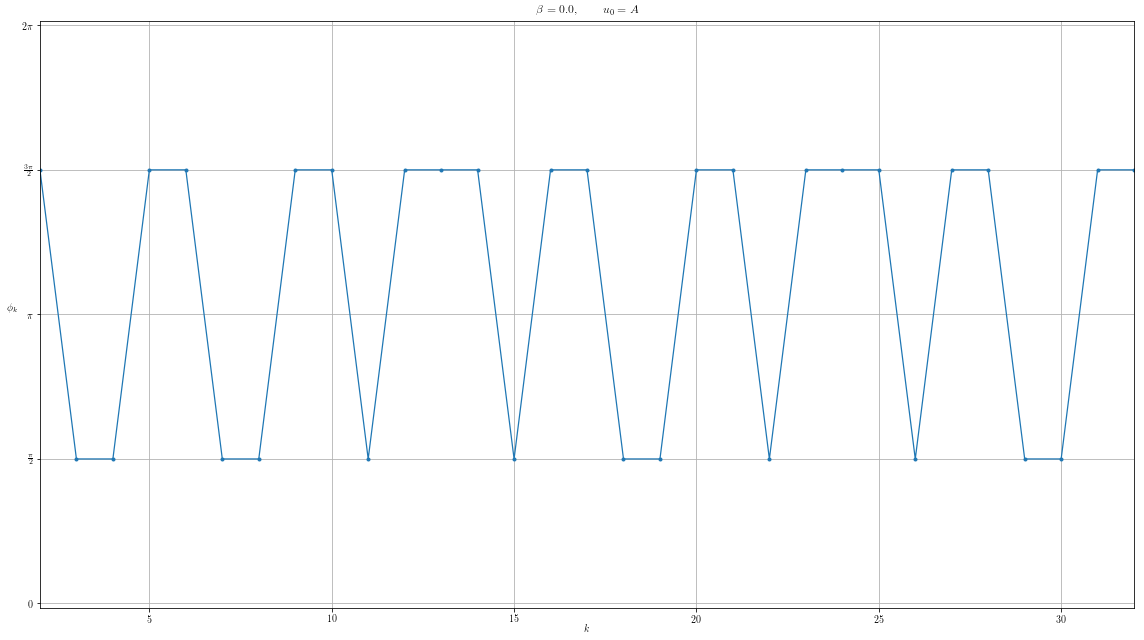

[0.         0.         4.71238898 1.57079633 1.57079633 4.71238898
 4.71238898 1.57079633 1.57079633 4.71238898 4.71238898 1.57079633
 4.71238898 4.71238898 4.71238898 1.57079633 4.71238898 4.71238898
 1.57079633 1.57079633 4.71238898 4.71238898 1.57079633 4.71238898
 4.71238898 4.71238898 1.57079633 4.71238898 4.71238898 1.57079633
 1.57079633 4.71238898 4.71238898 1.57079633 1.57079633 4.71238898
 1.57079633 1.57079633 1.57079633 4.71238898 1.57079633 1.57079633
 4.71238898 4.71238898 1.57079633 1.57079633 4.71238898 1.57079633
 1.57079633 1.57079633 4.71238898 1.57079633 1.57079633 4.71238898
 4.71238898 1.57079633 1.57079633 4.71238898 4.71238898 1.57079633
 4.71238898 4.71238898 4.71238898 1.57079633 4.71238898 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0

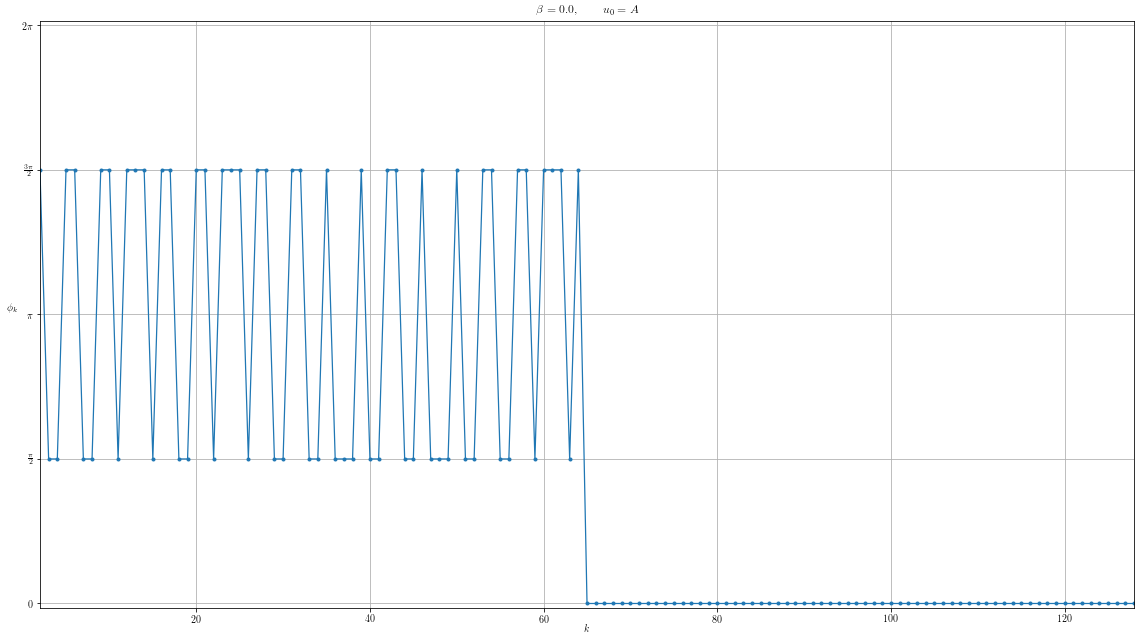

[0.         0.         4.71238898 1.57079633 1.57079633 4.71238898
 4.71238898 1.57079633 1.57079633 4.71238898 4.71238898 1.57079633
 4.71238898 4.71238898 4.71238898 1.57079633 4.71238898 4.71238898
 1.57079633 1.57079633 4.71238898 4.71238898 1.57079633 4.71238898
 4.71238898 4.71238898 1.57079633 4.71238898 4.71238898 1.57079633
 1.57079633 4.71238898 4.71238898 1.57079633 1.57079633 4.71238898
 1.57079633 1.57079633 1.57079633 4.71238898 1.57079633 1.57079633
 4.71238898 4.71238898 1.57079633 1.57079633 4.71238898 1.57079633
 1.57079633 1.57079633 4.71238898 1.57079633 1.57079633 4.71238898
 4.71238898 1.57079633 1.57079633 4.71238898 4.71238898 1.57079633
 4.71238898 4.71238898 4.71238898 1.57079633 4.71238898 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0

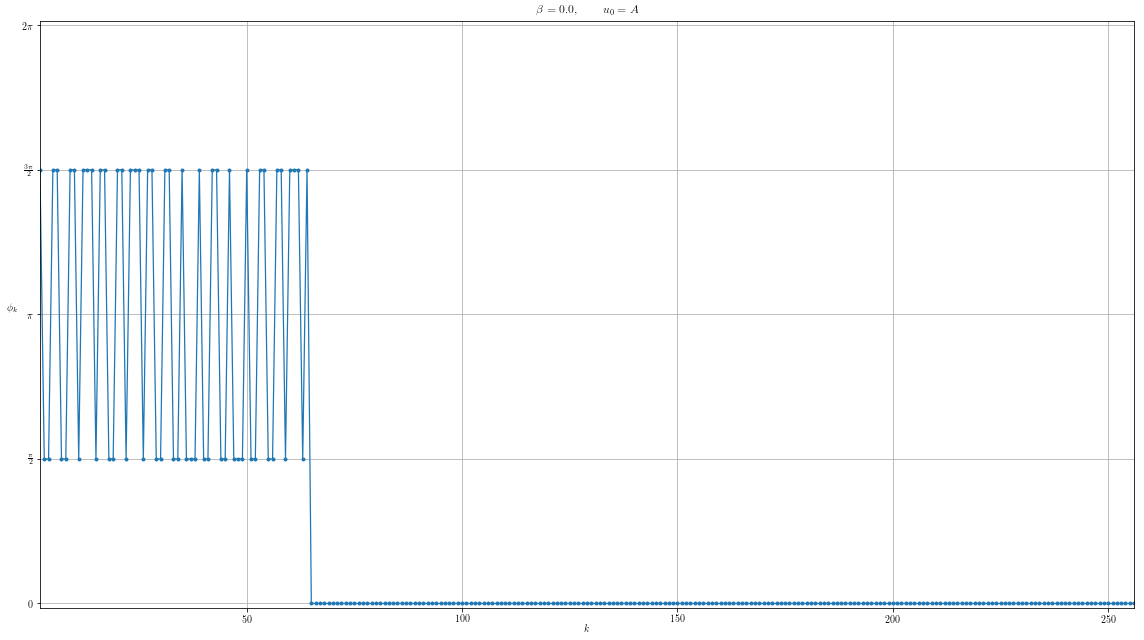

In [162]:
## Create initial conditions using fixed point C for larger systems
u0 = "C_ZERO"
N = [64, 256, 512] 

for n in N:
    new_fixed_pt = np.zeros((int(n/2 + 1),))

    random.seed(123456789)

    for i in range(len(new_fixed_pt)):
        if i < len(fixedpt_phi):
            new_fixed_pt[i] = np.mod(fixedpt_phi[i], 2.0*np.pi)
        elif u0 == "C_RANDOM":
            new_fixed_pt[i] = random.random() * 2.0 * np.pi
        elif u0 == "C_ZERO":
            new_fixed_pt[i] = 0.0
        else:
            num = random.getrandbits(1)
            new_fixed_pt[i] = np.mod(((-1)**num) * np.pi / 2, 2.0 * np.pi)

    print(new_fixed_pt)

    mpl.rcParams['figure.figsize'] = [16, 9]
    plt.plot(np.arange(kmin, n/ 2 + 1), new_fixed_pt[kmin:], '.-')
    plt.xlim(kmin, n/ 2)
    plt.ylim([0- 0.05, 2 * np.pi + 0.05])
    # plt.ylim([-2 * np.pi + 0.05, 2 * np.pi + 0.05])
    plt.xlabel(r'$k$', labelpad = 0)
    plt.ylabel(r'$\phi_k$', rotation = 0, labelpad = 10)
    plt.title(r"$\beta = {}, \qquad u_0 = {}$".format(0.0, "A") )
    # plt.xticks(np.arange(kmin, num_osc), np.arange(kmin, num_osc))
    plt.yticks([0, np.pi / 2.0, np.pi, 3.0 * np.pi / 2.0, 2.0 * np.pi], [r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"])
    # plt.yticks(np.append(np.flipud([-np.pi / 2.0, -np.pi, -3.0 * np.pi / 2.0, -2.0 * np.pi]), [0, np.pi / 2.0, np.pi, 3.0 * np.pi / 2.0, 2.0 * np.pi]), np.append(np.flipud([r"$-\frac{\pi}{2}$", r"$-\pi$", r"$-\frac{3\pi}{2}$", r"$-2\pi$"]),[r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]))
    plt.grid(True)
    plt.show()


    np.savetxt("../Data/Input/Initial_Conditions/FixedPoint_N[{}]_k0[{}]_BETA[{:0.3f}]_u0[{}].txt".format(n, k0, beta, u0),  np.mod(new_fixed_pt, 2.0*np.pi), fmt = "%20.16f")

### Fixed Point D - 

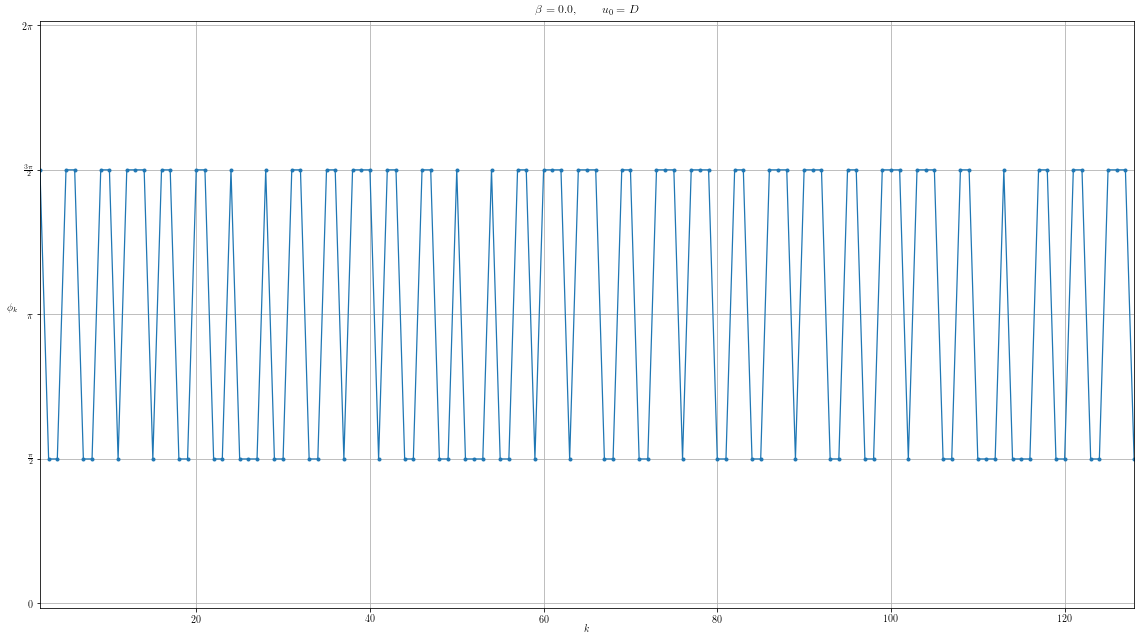

In [184]:
u0 = "D"
N = 256;
num_osc = int(N / 2 + 1);
kmin    = int(k0 + 1);
kmax    = int(N / 2);


triadarr = -10.0 * np.ones(num_osc)
triadarr[kmin:]                                                        = np.pi/2
triadarr[[10, 12, 14, 23, 25, 27, 36, 38, 40, 49, 51, 53, 58, 60, 62, 64, 73, 75, 77, 86, 88, 90, 99, 101, 103, 110, 112, 114, 125]] = -np.pi/2 #
# print(triadarr)

fixedpt_phi = np.zeros(len(np.arange(0, kmax + 1)))
len(fixedpt_phi)

# initial phase values, worked out by hand
fixedpt_phi[kmin]     = 3.0*np.pi /2.0       # phi_2
fixedpt_phi[kmin + 1] = 5.0*np.pi /2.0             # phi_3


for k in range(kmin, kmax - kmin + 1):
    fixedpt_phi[k + 2] = -triadarr[k] + fixedpt_phi[k] + fixedpt_phi[kmin]

# print(fixedpt_phi)
# print(np.mod(fixedpt_phi, 2.0*np.pi))

mpl.rcParams['figure.figsize'] = [16, 9]
plt.plot(np.arange(kmin, num_osc), np.mod(fixedpt_phi[kmin:], 2*np.pi), '.-')
plt.xlim(kmin, kmax)
plt.ylim([0- 0.05, 2 * np.pi + 0.05])
# plt.ylim([-2 * np.pi + 0.05, 2 * np.pi + 0.05])
plt.xlabel(r'$k$', labelpad = 0)
plt.ylabel(r'$\phi_k$', rotation = 0, labelpad = 10)
plt.title(r"$\beta = {}, \qquad u_0 = {}$".format(0.0, u0) )
# plt.xticks(np.arange(kmin, num_osc), np.arange(kmin, num_osc))
plt.yticks([0, np.pi / 2.0, np.pi, 3.0 * np.pi / 2.0, 2.0 * np.pi], [r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"])
# plt.yticks(np.append(np.flipud([-np.pi / 2.0, -np.pi, -3.0 * np.pi / 2.0, -2.0 * np.pi]), [0, np.pi / 2.0, np.pi, 3.0 * np.pi / 2.0, 2.0 * np.pi]), np.append(np.flipud([r"$-\frac{\pi}{2}$", r"$-\pi$", r"$-\frac{3\pi}{2}$", r"$-2\pi$"]),[r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]))
plt.grid(True)
plt.show()

np.savetxt("../Data/Input/Fixed_Points/FixedPoint_N[{}]_k0[{}]_BETA[{:0.3f}]_u0[{}].txt".format(N, k0, beta, u0),  np.mod(new_fixed_pt, 2.0*np.pi), fmt = "%20.16f")
np.savetxt("../Data/Input/Initial_Conditions/FixedPoint_N[{}]_k0[{}]_BETA[{:0.3f}]_u0[{}].txt".format(N, k0, beta, u0),  np.mod(new_fixed_pt, 2.0*np.pi), fmt = "%20.16f")

[0.         0.         4.71238898 1.57079633 1.57079633 4.71238898
 4.71238898 1.57079633 1.57079633 4.71238898 4.71238898 1.57079633
 4.71238898 4.71238898 4.71238898 1.57079633 4.71238898 4.71238898
 1.57079633 1.57079633 4.71238898 4.71238898 1.57079633 1.57079633
 4.71238898 1.57079633 1.57079633 1.57079633 4.71238898 1.57079633
 1.57079633 4.71238898 4.71238898]


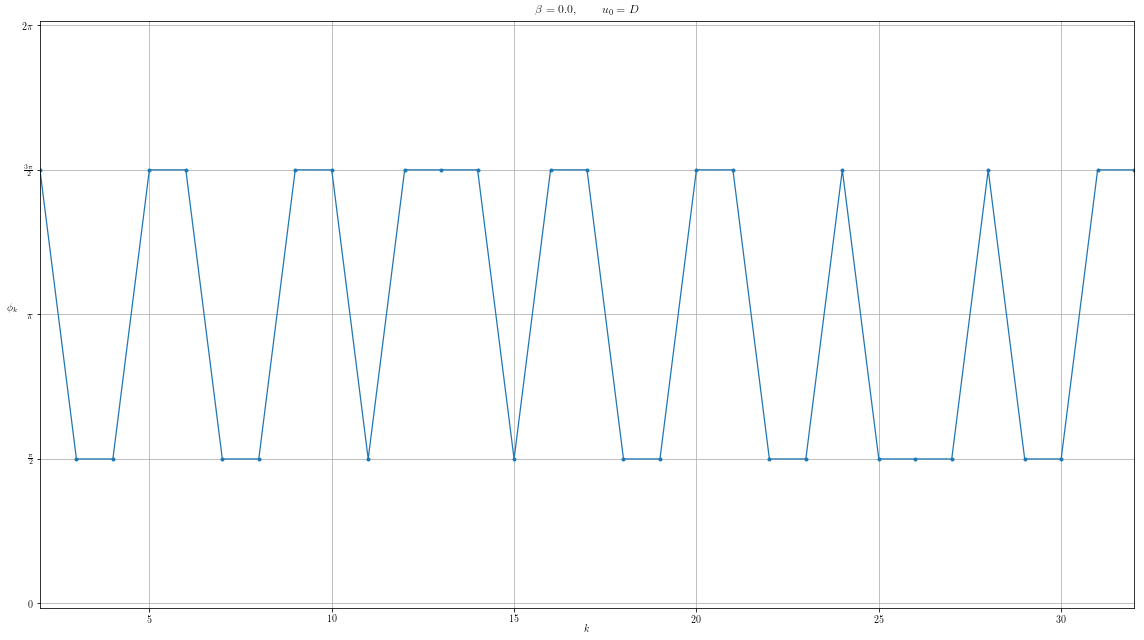

[0.         0.         4.71238898 1.57079633 1.57079633 4.71238898
 4.71238898 1.57079633 1.57079633 4.71238898 4.71238898 1.57079633
 4.71238898 4.71238898 4.71238898 1.57079633 4.71238898 4.71238898
 1.57079633 1.57079633 4.71238898 4.71238898 1.57079633 1.57079633
 4.71238898 1.57079633 1.57079633 1.57079633 4.71238898 1.57079633
 1.57079633 4.71238898 4.71238898 1.57079633 1.57079633 4.71238898
 4.71238898 1.57079633 4.71238898 4.71238898 4.71238898 1.57079633
 4.71238898 4.71238898 1.57079633 1.57079633 4.71238898 4.71238898
 1.57079633 1.57079633 4.71238898 1.57079633 1.57079633 1.57079633
 4.71238898 1.57079633 1.57079633 4.71238898 4.71238898 1.57079633
 4.71238898 4.71238898 4.71238898 1.57079633 4.71238898]


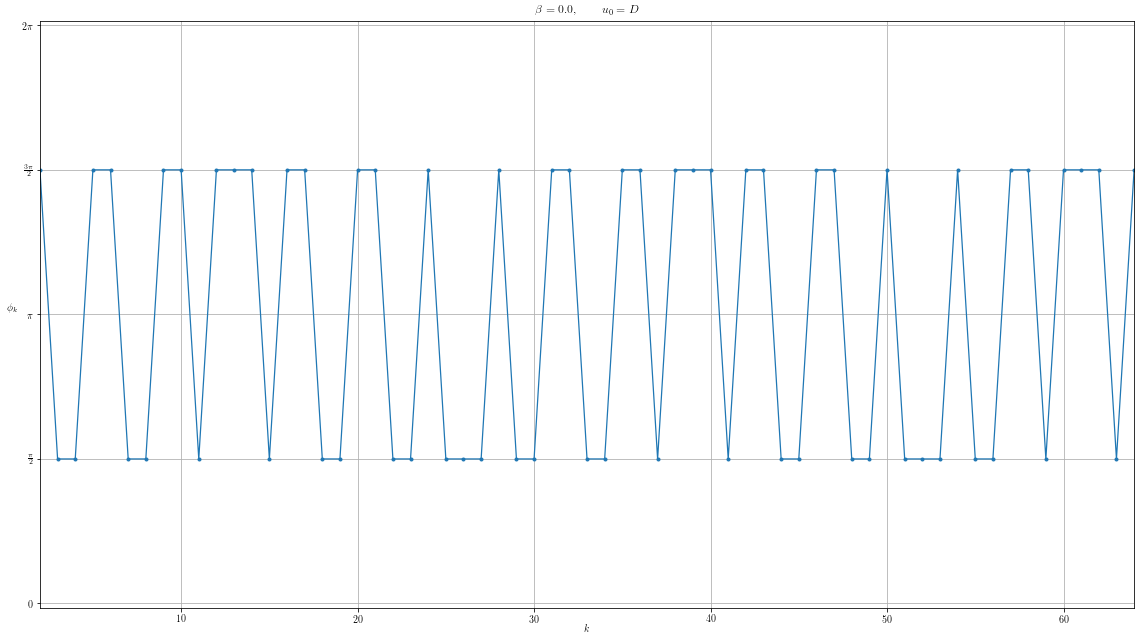

[0.         0.         4.71238898 1.57079633 1.57079633 4.71238898
 4.71238898 1.57079633 1.57079633 4.71238898 4.71238898 1.57079633
 4.71238898 4.71238898 4.71238898 1.57079633 4.71238898 4.71238898
 1.57079633 1.57079633 4.71238898 4.71238898 1.57079633 1.57079633
 4.71238898 1.57079633 1.57079633 1.57079633 4.71238898 1.57079633
 1.57079633 4.71238898 4.71238898 1.57079633 1.57079633 4.71238898
 4.71238898 1.57079633 4.71238898 4.71238898 4.71238898 1.57079633
 4.71238898 4.71238898 1.57079633 1.57079633 4.71238898 4.71238898
 1.57079633 1.57079633 4.71238898 1.57079633 1.57079633 1.57079633
 4.71238898 1.57079633 1.57079633 4.71238898 4.71238898 1.57079633
 4.71238898 4.71238898 4.71238898 1.57079633 4.71238898 4.71238898
 4.71238898 1.57079633 1.57079633 4.71238898 4.71238898 1.57079633
 1.57079633 4.71238898 4.71238898 4.71238898 1.57079633 4.71238898
 4.71238898 4.71238898 1.57079633 1.57079633 4.71238898 4.71238898
 1.57079633 1.57079633 4.71238898 4.71238898 4.71238898 1.5707

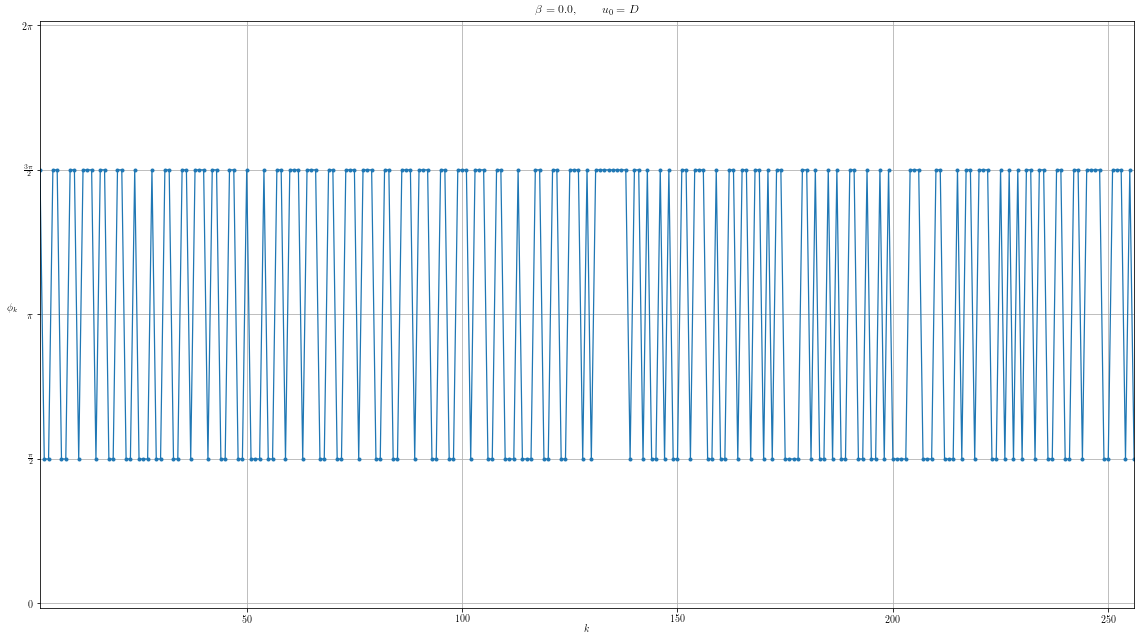

In [185]:
## Create initial conditions using fixed point C for larger systems
u0 = "D"
N = [64, 128, 512] 

for n in N:
    new_fixed_pt = np.zeros((int(n/2 + 1),))

    random.seed(123456789)

    for i in range(len(new_fixed_pt)):
        if i < len(fixedpt_phi):
            new_fixed_pt[i] = np.mod(fixedpt_phi[i], 2.0*np.pi)
        elif u0 == "D_RANDOM":
            new_fixed_pt[i] = random.random() * 2.0 * np.pi
        elif u0 == "D_ZERO":
            new_fixed_pt[i] = 0.0
        else:
            num = random.getrandbits(1)
            new_fixed_pt[i] = np.mod(((-1)**num) * np.pi / 2, 2.0 * np.pi)

    print(new_fixed_pt)

    mpl.rcParams['figure.figsize'] = [16, 9]
    plt.plot(np.arange(kmin, n/ 2 + 1), new_fixed_pt[kmin:], '.-')
    plt.xlim(kmin, n/ 2)
    plt.ylim([0- 0.05, 2 * np.pi + 0.05])
    # plt.ylim([-2 * np.pi + 0.05, 2 * np.pi + 0.05])
    plt.xlabel(r'$k$', labelpad = 0)
    plt.ylabel(r'$\phi_k$', rotation = 0, labelpad = 10)
    plt.title(r"$\beta = {}, \qquad u_0 = {}$".format(0.0, u0) )
    # plt.xticks(np.arange(kmin, num_osc), np.arange(kmin, num_osc))
    plt.yticks([0, np.pi / 2.0, np.pi, 3.0 * np.pi / 2.0, 2.0 * np.pi], [r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"])
    # plt.yticks(np.append(np.flipud([-np.pi / 2.0, -np.pi, -3.0 * np.pi / 2.0, -2.0 * np.pi]), [0, np.pi / 2.0, np.pi, 3.0 * np.pi / 2.0, 2.0 * np.pi]), np.append(np.flipud([r"$-\frac{\pi}{2}$", r"$-\pi$", r"$-\frac{3\pi}{2}$", r"$-2\pi$"]),[r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]))
    plt.grid(True)
    plt.show()


    np.savetxt("../Data/Input/Initial_Conditions/FixedPoint_N[{}]_k0[{}]_BETA[{:0.3f}]_u0[{}].txt".format(n, k0, beta, u0),  np.mod(new_fixed_pt, 2.0*np.pi), fmt = "%20.16f")